In [1]:
import numpy as np
import cv2
import imutils

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression

In [3]:
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    
    image = img_to_array(image)
    image = preprocess_input(image)
    
    return image

In [4]:
def selective_search(image, method='fast'):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    
    if method == "fast":
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()

    return rects

In [5]:
def non_max_suppression_indice(boxes, classes, max_bbox_overlap):
    """Suppress overlapping detections
        Returns indices of detections that have survived non-maxima suppression.
    """
    if len(boxes) == 0:
        return []

    boxes = boxes.astype(np.float)
    pick = []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] 
    y2 = boxes[:, 3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(
            idxs, np.concatenate(
                ([last], np.where(overlap > max_bbox_overlap)[0])))

    return pick

In [6]:
def get_boxes_and_proposals(image):
    rects = selective_search(image)
    proposals = []
    boxes = []
    (H, W) = image.shape[:2]
    for (x,y,w,h) in rects:
        
        if w / float(W) < 0.1 or h / float(H) < 0.1:
            continue 
        im = image[y:y+h, x:x+w]
        proposals.append(preprocess_image(im))
        boxes.append((x,y,w,h))
        
    
    proposals = np.array(proposals)
    
    return proposals, boxes

In [14]:
model = ResNet50(weights="imagenet")

In [15]:
def prediction(image,model):
    
    model = ResNet50(weights="imagenet")
    proposals, boxes = get_boxes_and_proposals(image)
    preds = model.predict(proposals)
    preds = imagenet_utils.decode_predictions(preds,top=5)
    
    labels = {}
    for i in  range(len(preds)):
        for pred in preds[i]:
            if pred[1] in ['desk', 'violin', 'tennis_ball', 'hammer', 'umbrella'] and pred[2]>0.8:
                L = labels.get(pred[1],[])
                (x,y,w,h) = boxes[i]
                L.append(((x,y,x+w,y+h),pred[2]))
                labels[pred[1]] = L
    return labels

In [16]:
def suppression_redondance(labels):
    l = {}
    for label in labels:
        boxes = np.array([p[0] for p in labels[label]] )
        preds = np.array([p[1] for p in labels[label]])
        indices = non_max_suppression_indice(boxes,preds,0.3)
        
        l[label] = (boxes[indices],preds[indices])
        
    return l

In [17]:
def detect_objet(path):
    image = cv2.imread(path)
    labels = prediction(image,model)
    labels = suppression_redondance(labels)
    clone = cv2.imread(path) 
    for label in labels:
        boxes, preds = labels[label]
        for (i,(startX, startY, endX, endY)) in enumerate(boxes):
            cv2.rectangle(clone, (startX,startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone, label+str(preds[i]), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    return clone

In [23]:
img = detect_objet("test11.jpg")
#cv2.imshow("After", img)
cv2.imwrite("after.jpg",img)
cv2.waitKey(0)

-1

In [19]:
def drow_boxes(path):
    #etape1
    image = cv2.imread(path)
    clone1 = cv2.imread(path)
    clone2 = cv2.imread(path)
    clone3 = cv2.imread(path)
    
    #etape2
    proposals, boxes = get_boxes_and_proposals(image)
    for x,y,w,h in boxes:
        cv2.rectangle(clone1, (x,y), (x+w, y+h),(0, 255, 0), 2)
    #etape3
    labels = prediction(image,model)
    for label in labels:
        boxes = [p[0] for p in labels[label]]
    for x,y,x2,y2 in boxes:
        cv2.rectangle(clone2, (x,y), (x2, y2),(0, 255, 0), 2)
    
    #etape4
    labels = suppression_redondance(labels)
    for label in labels:
        boxes, preds = labels[label]
        for (i,(startX, startY, endX, endY)) in enumerate(boxes):
            cv2.rectangle(clone3, (startX,startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(clone3, label+str(preds[i]), (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
            
            
    return image, clone1, clone2, clone3

In [21]:
import matplotlib.pyplot as plt
imgs = drow_boxes("test11.jpg")

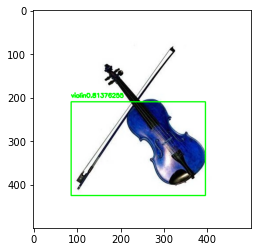

In [22]:
plt.imshow(imgs[3])